# Coal production in mines 2013

by: Charles Wolfe

Abstract: We did alot of analysis, came to good conclusion.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error

sns.set();

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Cleaned Data

We cleaned this data in the notebook stored in: deliver/Data_cleaning.ipynb

In [2]:
df1 = pd.read_csv("../data/cleaned_coalpublic2013.csv", index_col='MSHA ID')
df1[['year', 'mine_name']].head()

,year,mine_name
MSHA ID,,
103381,2013,Tacoa Highwall Miner
103404,2013,Reid School Mine
100759,2013,North River #1 Underground Min
103246,2013,Bear Creek
103451,2013,Knight Mine


# Predict the Production of coal mines

In [3]:
df1['log_production'] = np.log(df1['production_(short_tons)'])
df1.union_code.unique()

array([' ', 'UNIT', 'United Mine Workers of America', 'INTE',
       'International Union of Operation Engineers',
       'Scotia Employees Association', 'Western Energy Workers'], dtype=object)

In [4]:
features = ['average_employees',
            'labor_hours']

categoricals = ['mine_state',
                'mine_county',
                'mine_status',
                'mine_type',
                'company_type',
                'operation_type',
                'operating_company',
                'union_code',
                'coal_supply_region']

target = 'log_production'

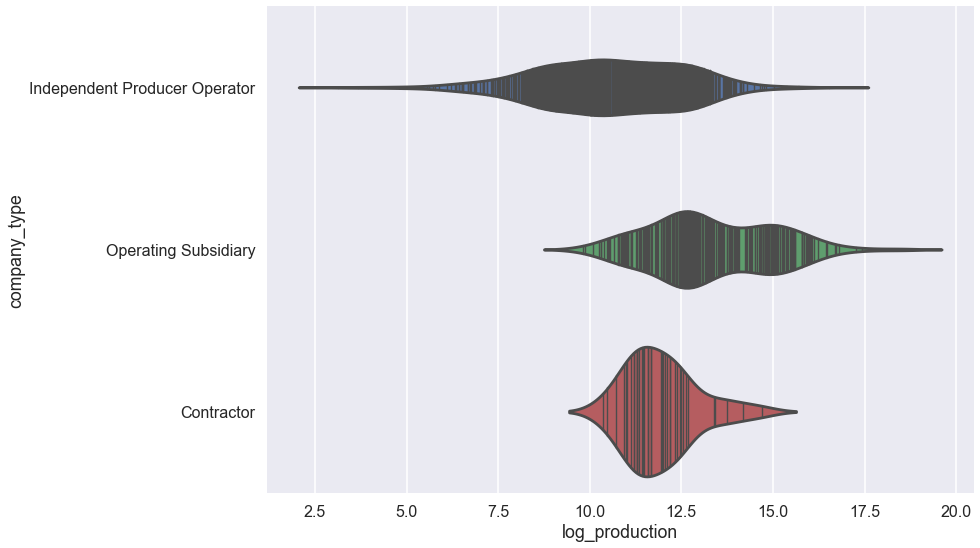

In [12]:
sns.set_context('poster')
fig = plt.subplots(figsize=(14,8))
sns.violinplot(y="company_type", x="log_production", data=df1,
              split=True, inner="stick")
plt.tight_layout()
plt.savefig("../figures/Coal_prediction_company_type_vs_log_production.png")

In [6]:
dummy_categoricals = []
for categorical in categoricals:
    # Avoid the dummy variable trap (need to remove one)!
    drop_var = sorted(df1[categorical].unique())[-1]
    temp_df = pd.get_dummies(df1[categorical], prefix=categorical)
    df1 = pd.concat([df1, temp_df], axis=1)
    temp_df.drop('_'.join([categorical, str(drop_var)]), axis=1, inplace=True)
    dummy_categoricals += temp_df.columns.tolist()

# Random Forest Regressor

In [7]:
train, test = train_test_split(df1, test_size=0.3)

In [8]:
rf = RandomForestRegressor(n_estimators=100, oob_score=True)
rf.fit(train[features + dummy_categoricals], train[target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

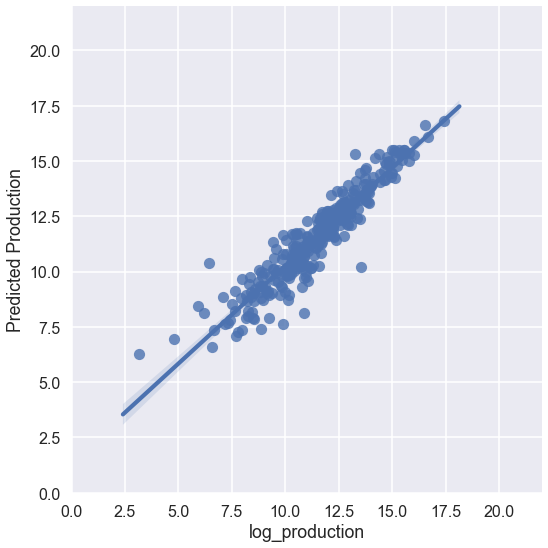

In [9]:
fig = plt.subplots(figsize=(8,8))
sns.regplot(test[target], rf.predict(test[features + dummy_categoricals]))
plt.ylabel("Predicted Production")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.tight_layout()
plt.savefig("../figures/Coal_prediction_rf_predition.png")

In [10]:
predicted = rf.predict(test[features + dummy_categoricals])
print "R^2 score: ", r2_score(test[target], predicted)

print "MSE: ", mean_squared_error(test[target], predicted)

R^2 score:  0.878509509047
MSE:  0.597526009399


In [11]:
rf_importances = pd.DataFrame({'name':train[features + dummy_categoricals].columns,
                              'importance':rf.feature_importances_
                              }).sort_values(by='importance', ascending=False).reset_index(drop=True)
rf_importances.head(5)

,importance,name
0,0.816212,labor_hours
1,0.070736,average_employees
2,0.008354,mine_type_Surface
3,0.006798,coal_supply_region_Powder River Basin
4,0.004903,operating_company_Commonwealth Environmental Sys


# Conclusion

A detailed and amazing conclusion